In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

2022-07-29 17:33:14.504809: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
n = 8
n_node = 8

In [3]:
K = tc.set_backend('jax')

In [4]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]

x_train = x_train / 255.0
mean = jnp.mean(x_train, axis=0)
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

y_train = jax.nn.one_hot(y_train, n_node)

2022-07-29 17:33:27.538884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 17:33:29.867373: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-29 17:33:29.867420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29659 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:13:00.0, compute capability: 7.0


In [5]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return -jnp.mean(y * jnp.log(probs) + (1 - y) * jnp.log(1 - probs))
loss = K.jit(loss, static_argnums=[3, 4])

In [6]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3, 4])

In [7]:
k = 50

In [8]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/469: loss=0.3561, acc=0.2422
epoch 0, 30/469: loss=0.1539, acc=0.7109
epoch 0, 60/469: loss=0.1737, acc=0.5781
epoch 0, 90/469: loss=0.1514, acc=0.6719
epoch 0, 120/469: loss=0.1307, acc=0.7734
epoch 0, 150/469: loss=0.1263, acc=0.7812
epoch 0, 180/469: loss=0.1325, acc=0.7266
epoch 0, 210/469: loss=0.1165, acc=0.7344
epoch 0, 240/469: loss=0.1357, acc=0.7266
epoch 0, 270/469: loss=0.1291, acc=0.6875
epoch 0, 300/469: loss=0.1248, acc=0.7266
epoch 0, 330/469: loss=0.1232, acc=0.7344
epoch 0, 360/469: loss=0.1283, acc=0.7578
epoch 0, 390/469: loss=0.1336, acc=0.7266
epoch 0, 420/469: loss=0.1140, acc=0.8047
epoch 0, 450/469: loss=0.1317, acc=0.6719
epoch 1, 0/469: loss=0.1125, acc=0.7578
epoch 1, 30/469: loss=0.1082, acc=0.7578
epoch 1, 60/469: loss=0.1377, acc=0.6562
epoch 1, 90/469: loss=0.1226, acc=0.7891
epoch 1, 120/469: loss=0.1108, acc=0.7656
epoch 1, 150/469: loss=0.1230, acc=0.7500
epoch 1, 180/469: loss=0.1143, acc=0.7188
epoch 1, 210/469: loss=0.1082, acc=0.7734
ep

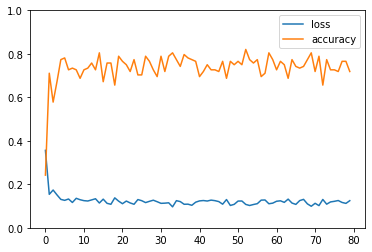

In [9]:
params_list = []
data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(128)

params = K.randn((k * 2, n), dtype=jnp.float32)
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

loss_list = []
acc_list = []
for e in tqdm(range(5), leave=False):
    for i, (x, y) in enumerate(data):
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params, x, y, k)
        updates, opt_state = opt.update(grad_val, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_mean = jnp.mean(loss_val)
        if i % 30 == 0:
            acc = jnp.mean(compute_accuracy(params, x, y, k))
            acc_list.append(acc)
            loss_list.append(loss_mean)
            print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 1)
plt.show()
